In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Simulating price impacts of different order sizes

This notebook contains simlations of how different order sizes impact premium price in pools of different size. 

## Table of Contents:
* [Deploying contracts](#Deploying-contracts)
* [Generating data](#Generating-data)
* [Plot summary](#Plot-summary)
* [Table summary](#Table-summary)
* [Verbose summary](#Verbose-summary)

**There were some changes done to the AMM itself, which won't be included in the commit, but can be easily reproducible:**

 - hardcoded price of ETH
     - changed value of underlying_price in amm.cairo 
     - to reproduce:
         - go to contracts/amm.cairo
         - search for 'let (underlying_price) = ...'
         - change that line to 'let (underlying_price) = Math64x61.fromFelt(x)'  where x is the price you wish to use
         - save file     
     
     
 -  hardcoded current block time in _time_till_maturity
     - changed currtime in amm.cairo to 1640991600 -> 31/12/2021 
     - to reproduce: 
         - go to contracts/amm.cairo
         - search for 'let (currtime) ...'
         - change that line to 'let currtime = x'  where x is timestamp in seconds

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from starkware.starknet.testing.starknet import Starknet
from starkware.starknet.testing.contract import StarknetContract
from starkware.starkware_utils.error_handling import StarkException

from aux import (
    USER_ID,
    STARTING_TOKEN_BALANCE_1,
    STARTING_TOKEN_BALANCE_2,
    STRIKE_PRICE,
    do_trade,
    show_current_premium,
    MATURITY,
    show_pool_volatility,
    AmmContract
)


In [19]:
# Set current price for trades here
CURRENT_PRICE = 1200

### Deploying contracts

In [ ]:
net = await Starknet.empty()

In [ ]:
# Function that will deploy Amm contract, add tokens for the user and return the contract
async def deploy_and_add_tokens(pool_size: int) -> AmmContract:
    mm = await net.deploy(source = os.path.join('..', '..', 'contracts/main.cairo'), 
    cairo_path = ['../..', 
                 '../../lib/cairo_math_64x61/contracts/cairo_math_64x61',
                 '../../contracts'])
    print(f'Initializing pool with pool size: {pool_size / 2**61:_}')
    await mm.init_pool(
        pool_size, # Call balance
        pool_size * CURRENT_PRICE # Put balance
    ).invoke()
    return mm

In [11]:
# Define pool and order sizes to test

pool_sizes = [10_000, 20_000, 35_000 ,75_000]

# Define weights of trades -> proportion of the pool that is to be traded
weights = [0.0025, 0.005, 0.0075, 0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.9]

In [ ]:
# Deploy contracts and store them in dict for easier iteration

data = {
    pool_size : {
        'func': await deploy_and_add_tokens(pool_size * 2 ** 61)
    } for pool_size in pool_sizes
}

### Generating data

In [ ]:
for key in data.keys():
    data[key]['records'] = []
    print(f'Working on amm with pool size: {key:_}')
    
    order_sizes = [weight*key for weight in weights]
    for order_size in order_sizes:
#         try: 
        tmp = {}
        tmp['order_size'] = order_size
        print(f'  Current order size: {order_size:_}')

        # Retrieve premium and volatility before trades
        tmp.update({f'init_{k}': value for k, value in (await show_current_premium(data[key]['func'], 1 * 2**61, True, CURRENT_PRICE)).items()})
        tmp.update({f'init_{k}': value for k, value in (await show_pool_volatility(data[key]['func'], True)).items()})
        await show_pool_volatility(data[key]['func'], False)

        # Conduct trades
        await do_trade(data[key]['func'], int(order_size * 2**61), 0, 0)
        await do_trade(data[key]['func'], int(CURRENT_PRICE *order_size * 2**61), 1, 0)

        # Retrieve premium and volatility after trades
        tmp.update({f'after_{k}': value for k, value in (await show_current_premium(data[key]['func'], 1 * 2**61, True, CURRENT_PRICE)).items()})
        tmp.update({f'after_{k}': value for k, value in (await show_pool_volatility(data[key]['func'], True)).items()})
        await show_pool_volatility(data[key]['func'], False)

        # Calculate changes in premium
        tmp['premium_change_CALL'] = tmp['after_prem_CALL'] - tmp['init_prem_CALL']
        tmp['premium_change_PUT'] = tmp['after_prem_PUT'] - tmp['init_prem_PUT']

        tmp['perc_premium_change_CALL'] =  (tmp['after_prem_CALL'] / tmp['init_prem_CALL'] - 1) * 100
        tmp['perc_premium_change_PUT'] = (tmp['after_prem_PUT'] / tmp['init_prem_PUT'] - 1) * 100

        tmp['volatility_change_CALL'] = tmp['after_pool_vol_CALL'] - tmp['init_pool_vol_CALL']
        tmp['volatility_change_PUT'] = tmp['after_pool_vol_PUT'] - tmp['init_pool_vol_PUT']

        tmp['perc_volatility_change_CALL'] = (tmp['after_pool_vol_CALL'] / tmp['init_pool_vol_CALL'] - 1) * 100
        tmp['perc_volatility_change_PUT'] = (tmp['after_pool_vol_PUT'] / tmp['init_pool_vol_PUT'] - 1 ) * 100

        data[key]['records'].append(tmp)

        # Reset the pools for the next order size simulation
        data[key]['func'] = await deploy_and_add_tokens(key * 2 ** 61)

#         except StarkException as e:
#             print(e)
#             print(f"  ERROR at order_size: {order_size:_}")
#             continue

**Errors indicate places where there wasnt enough funds in the pool.**

In [ ]:
!spd-say "DONE DONE DONE"

In [ ]:
# Remove Starknet Contracts from data because it's not serializable for pickle

for key in data.keys():
    del data[key]['func']

In [3]:
# Generating data can take quite a while, so it's provided in a pickle file
# with open('data_current_1200.pickle', 'wb') as f:
#     pickle.dump(data, f)

# with open('data_current_1200.pickle', 'rb') as f:
#     data = pickle.load(f)

<!-- Little easter egg :) -->

### Plot summary

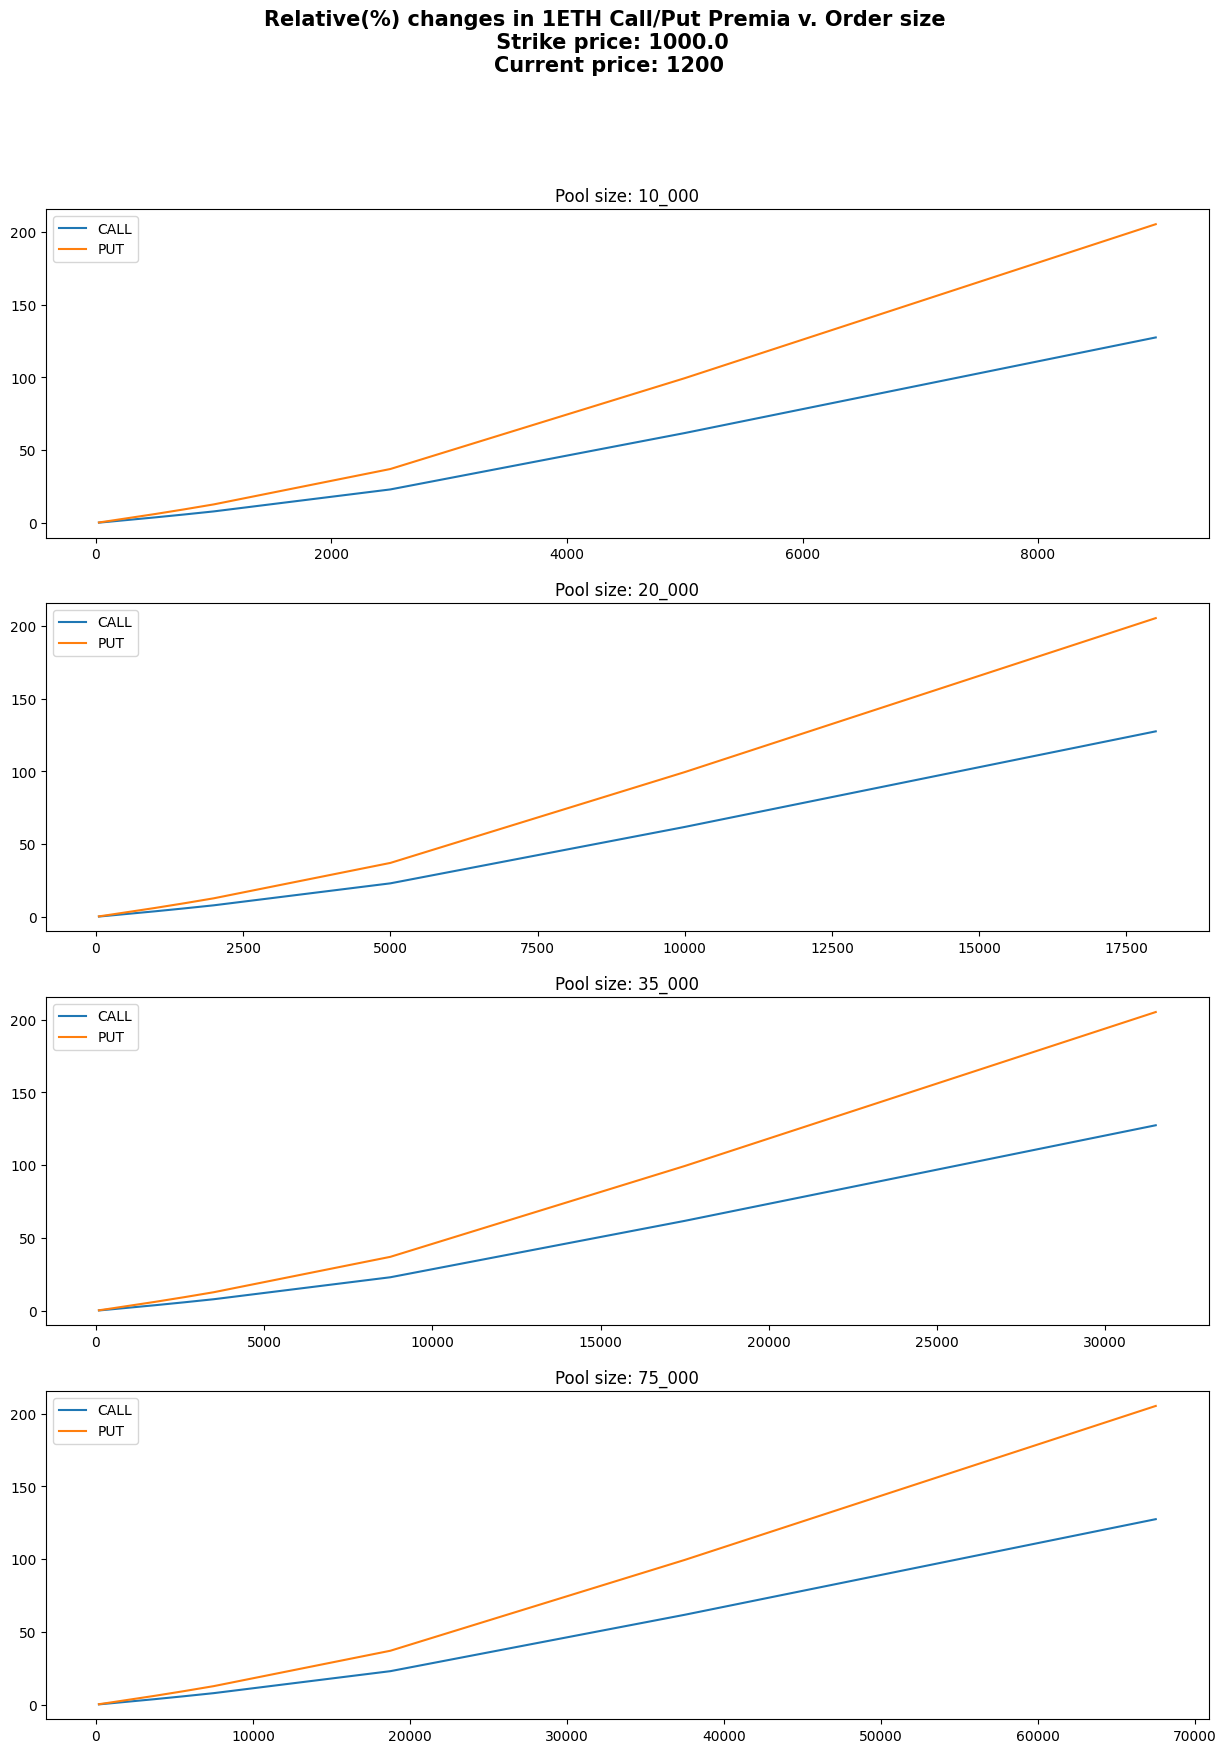

In [7]:
fig, ax = plt.subplots(ncols = 1, nrows = len(data.keys()))
fig.set_dpi(100)
fig.set_size_inches(15, 20)
fig.suptitle(f"Relative(%) changes in 1ETH Call/Put Premia v. Order size \n Strike price: {STRIKE_PRICE / 2**61}\nCurrent price: 1200", fontweight="bold",  size=15)

for ix, (key, value) in enumerate(data.items()):
    tmp = pd.DataFrame(value['records'])
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_CALL'], label = 'CALL')
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_PUT'], label = 'PUT')
    ax[ix].legend()
    ax[ix].set_title(f'Pool size: {key:_}')

Whole process is repeated, but now with hardcoded ETH price of $800.

In [8]:
# File containing data for sims with current price = 800 named data_current_800.pickle

# with open('data_current_800.pickle', 'rb') as f:
#     data_2 = pickle.load(f)

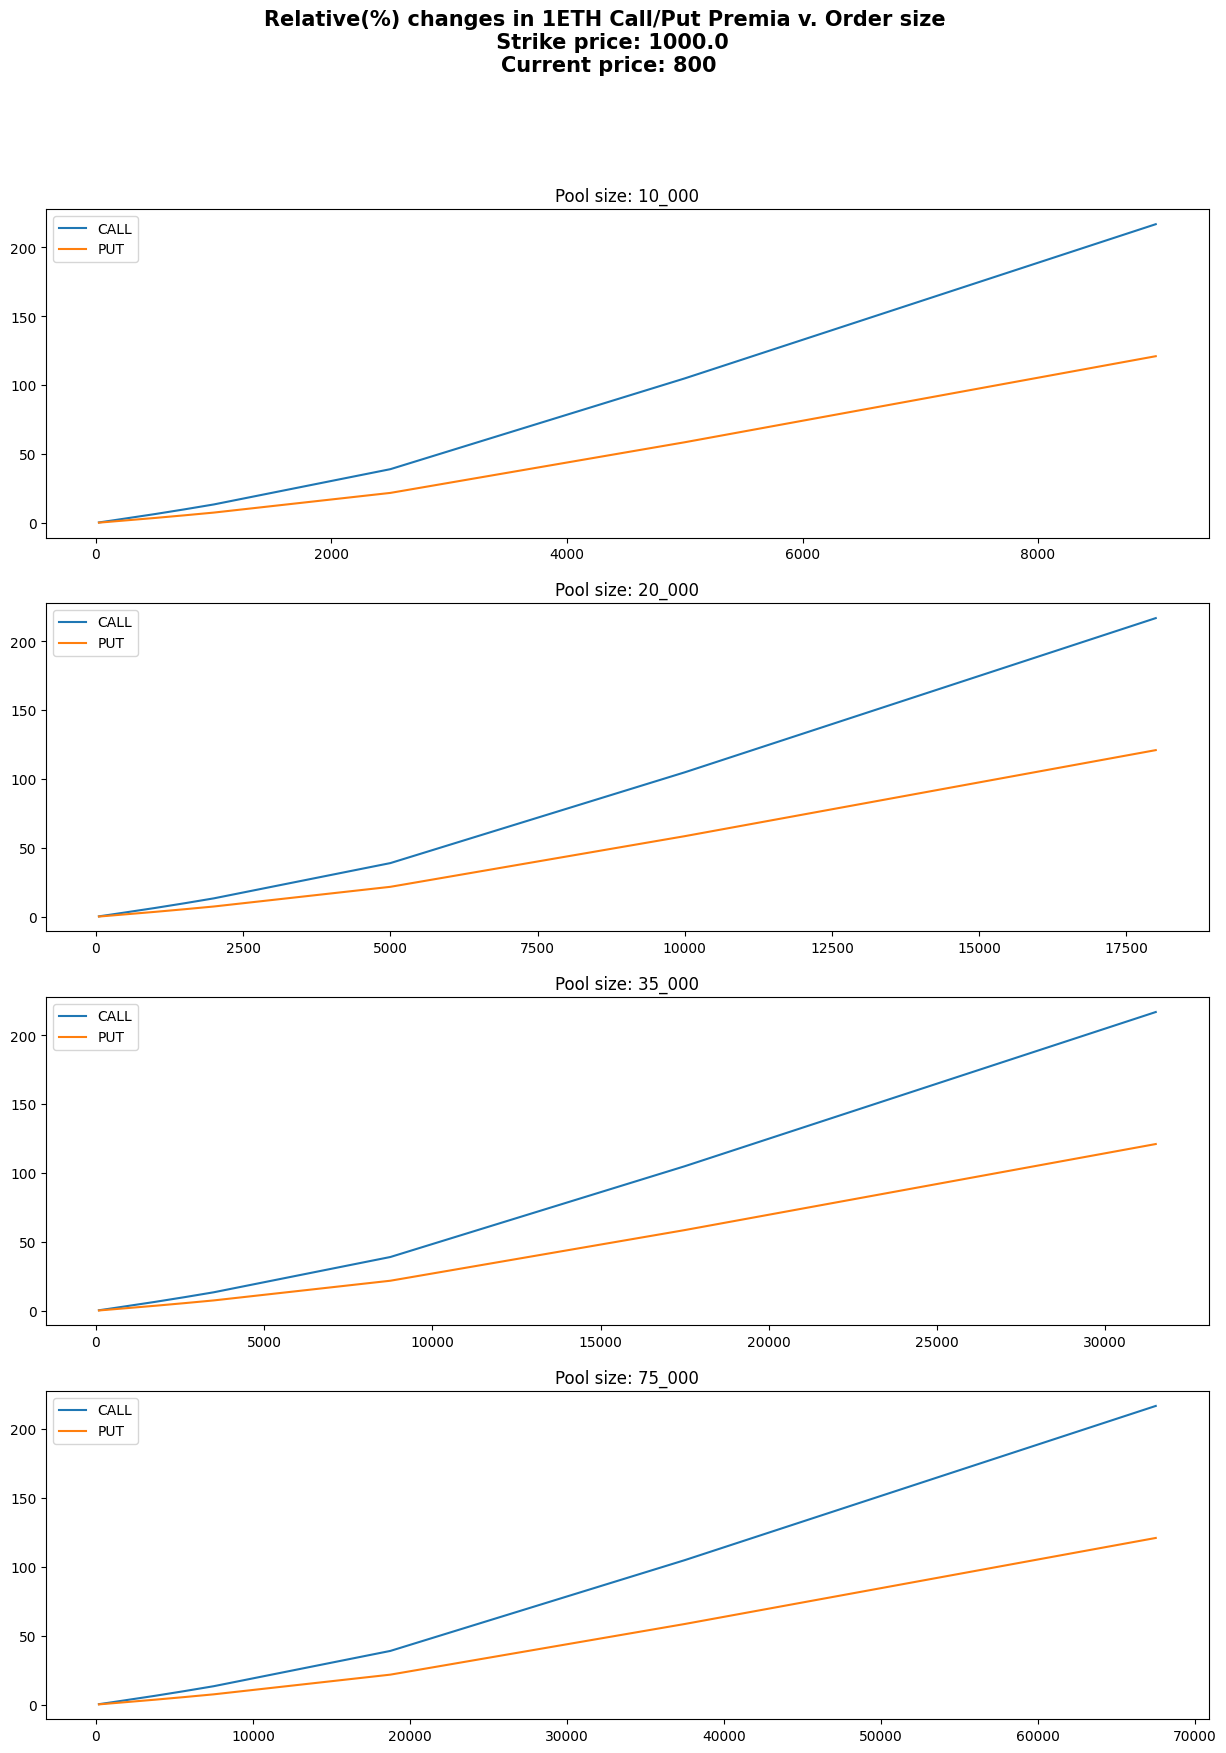

In [9]:
fig, ax = plt.subplots(ncols = 1, nrows = len(data_2.keys()))
fig.set_dpi(100)
fig.set_size_inches(15, 20)
fig.suptitle(f"Relative(%) changes in 1ETH Call/Put Premia v. Order size \n Strike price: {STRIKE_PRICE / 2**61}\nCurrent price: 800", fontweight="bold",  size=15)

for ix, (key, value) in enumerate(data_2.items()):
    tmp = pd.DataFrame(value['records'])
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_CALL'], label = 'CALL')
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_PUT'], label = 'PUT')
    ax[ix].legend()
    ax[ix].set_title(f'Pool size: {key:_}')

### Table summary

In [12]:
colnames = ['Order size as percentage of pool']
df_1 = []
df_1.append([str(i * 100) + '%' for i in weights])
for key, value in data.items():
    tmp = [str(round(i['perc_premium_change_CALL'], 4)) + '%' for i in value['records']]
    tmp2 = [str(round(i['perc_premium_change_PUT'], 4)) + '%' for i in value['records']]
    colnames.append(f"{key}_CALL")
    colnames.append(f"{key}_PUT")
    df_1.append(tmp)
    df_1.append(tmp2)
    
df_1 = pd.concat([pd.Series(i) for i in df_1], axis=1)
df_1 = df_1.rename(columns = {i: colnames[i] for i in df_1.columns})

df_2= []
df_2.append([str(i * 100) + '%' for i in weights])
for key, value in data_2.items():
    tmp = [str(round(i['perc_premium_change_CALL'], 4)) + '%' for i in value['records']]
    tmp2 = [str(round(i['perc_premium_change_PUT'], 4)) + '%' for i in value['records']]
    df_2.append(tmp)
    df_2.append(tmp2)

df_2 = pd.concat([pd.Series(i) for i in df_2], axis=1)
df_2 = df_2.rename(columns = {i: colnames[i] for i in df_2.columns})


In [13]:
print(f'Strike price: 1000, Current price: 1200')
df_1.set_index(r'Order size as percentage of pool')

Strike price: 1000, Current price: 1200


,10000_CALL,10000_PUT,20000_CALL,20000_PUT,35000_CALL,35000_PUT,75000_CALL,75000_PUT
Order size as percentage of pool,,,,,,,,
0.25%,0.1802%,0.2901%,0.1801%,0.2901%,0.1801%,0.2901%,0.1801%,0.2901%
0.5%,0.3611%,0.5816%,0.3611%,0.5816%,0.3611%,0.5816%,0.3611%,0.5816%
0.75%,0.5429%,0.8743%,0.5429%,0.8743%,0.5429%,0.8743%,0.5429%,0.8743%
1.0%,0.7255%,1.1684%,0.7255%,1.1684%,0.7255%,1.1684%,0.7254%,1.1684%
5.0%,3.7622%,6.0591%,3.7622%,6.0591%,3.7622%,6.0591%,3.7621%,6.0591%
7.5%,5.777%,9.3039%,5.7769%,9.3039%,5.7769%,9.3039%,5.7768%,9.3039%
10.0%,7.8887%,12.7047%,7.8885%,12.7047%,7.8885%,12.7047%,7.8885%,12.7047%
25.0%,22.9925%,37.0297%,22.9923%,37.0297%,22.9921%,37.0297%,22.992%,37.0297%
50.0%,61.7519%,99.4539%,61.7517%,99.4539%,61.7516%,99.4539%,61.7516%,99.4539%


In [14]:
print(f'Strike price: 1000, Current price: 800')
df_2.set_index(r'Order size as percentage of pool')

Strike price: 1000, Current price: 800


,10000_CALL,10000_PUT,20000_CALL,20000_PUT,35000_CALL,35000_PUT,75000_CALL,75000_PUT
Order size as percentage of pool,,,,,,,,
0.25%,0.3049%,0.1701%,0.3049%,0.1701%,0.3049%,0.1701%,0.3049%,0.1701%
0.5%,0.6111%,0.341%,0.6111%,0.341%,0.6111%,0.341%,0.6111%,0.341%
0.75%,0.9188%,0.5126%,0.9188%,0.5126%,0.9188%,0.5126%,0.9188%,0.5126%
1.0%,1.2278%,0.685%,1.2278%,0.685%,1.2278%,0.685%,1.2278%,0.685%
5.0%,6.3694%,3.5537%,6.3693%,3.5537%,6.3693%,3.5537%,6.3693%,3.5537%
7.5%,9.7822%,5.4578%,9.7821%,5.4578%,9.7821%,5.4578%,9.7821%,5.4578%
10.0%,13.3605%,7.4543%,13.3604%,7.4543%,13.3603%,7.4543%,13.3603%,7.4543%
25.0%,38.9873%,21.7526%,38.9872%,21.7526%,38.9871%,21.7526%,38.987%,21.7526%
50.0%,104.9146%,58.5372%,104.9152%,58.5372%,104.9154%,58.5372%,104.9156%,58.5372%


### Verbose summary

In [15]:
def print_info(data, strike, current):
    for key, item in data.items():
        print(f"For strike price {strike}, current price {current}, pool size {key:_} ETH")
        for trade in item['records']:
            print(f"   Call premium shifts by {trade['perc_premium_change_CALL']:.4f}% when we trade option of size {trade['order_size']} ETH ({trade['order_size'] / key:.2%} of the pool)")
            print(f"   Put premium shifts by {trade['perc_premium_change_PUT']:.4f}% when we trade option of size {trade['order_size']} ETH ({trade['order_size'] / key:.2%} of the pool)")
     

In [16]:
print_info(data, 1200, 1000)

For strike price 1200, current price 1000, pool size 10_000 ETH
   Call premium shifts by 0.1802% when we trade option of size 25.0 ETH (0.25% of the pool)
   Put premium shifts by 0.2901% when we trade option of size 25.0 ETH (0.25% of the pool)
   Call premium shifts by 0.3611% when we trade option of size 50.0 ETH (0.50% of the pool)
   Put premium shifts by 0.5816% when we trade option of size 50.0 ETH (0.50% of the pool)
   Call premium shifts by 0.5429% when we trade option of size 75.0 ETH (0.75% of the pool)
   Put premium shifts by 0.8743% when we trade option of size 75.0 ETH (0.75% of the pool)
   Call premium shifts by 0.7255% when we trade option of size 100.0 ETH (1.00% of the pool)
   Put premium shifts by 1.1684% when we trade option of size 100.0 ETH (1.00% of the pool)
   Call premium shifts by 3.7622% when we trade option of size 500.0 ETH (5.00% of the pool)
   Put premium shifts by 6.0591% when we trade option of size 500.0 ETH (5.00% of the pool)
   Call premium s

In [17]:
print_info(data_2, 800, 1000)

For strike price 800, current price 1000, pool size 10_000 ETH
   Call premium shifts by 0.3049% when we trade option of size 25.0 ETH (0.25% of the pool)
   Put premium shifts by 0.1701% when we trade option of size 25.0 ETH (0.25% of the pool)
   Call premium shifts by 0.6111% when we trade option of size 50.0 ETH (0.50% of the pool)
   Put premium shifts by 0.3410% when we trade option of size 50.0 ETH (0.50% of the pool)
   Call premium shifts by 0.9188% when we trade option of size 75.0 ETH (0.75% of the pool)
   Put premium shifts by 0.5126% when we trade option of size 75.0 ETH (0.75% of the pool)
   Call premium shifts by 1.2278% when we trade option of size 100.0 ETH (1.00% of the pool)
   Put premium shifts by 0.6850% when we trade option of size 100.0 ETH (1.00% of the pool)
   Call premium shifts by 6.3694% when we trade option of size 500.0 ETH (5.00% of the pool)
   Put premium shifts by 3.5537% when we trade option of size 500.0 ETH (5.00% of the pool)
   Call premium sh